# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [1]:
import umbridge
import qmcpy as qp
import numpy as np
import time

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [2]:
!docker rm -f muqbq_new
!docker run --name muqbq_new -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

muqbq_new
adbd1925587dd887efc89f14a90f9c8e93554bc29fdd134222179c0141390ddc


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [12]:
sampler = qp.DigitalNetB2(dimension=31,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.05) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [4]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31
umbridge_config = {}
#DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)

def lump(t):
    tnp = np.array(t[0])
    """
    #Model 1: fill with ones
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    """
    #Model 2: duplicating values
    tnewnp = np.ones(output_dimension)
    if len(tnp) < output_dimension:
        root = output_dimension // len(tnp)
        for i in range(root + output_dimension % len(tnp)):
            tnewnp[i] = tnp[0]
        #len(tnp) * root + output_dimension % len(tnp) = len(tnp)
        for j in range(1, len(tnp)):
            for i in range(j * root + output_dimension % len(tnp), (j+1) * root + output_dimension % len(tnp)):
                tnewnp[i] = tnp[j]
    #Model 3: approximating/smushing
    #else:
        #print("not exact")
    
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = lump) # INTEGRAND

{}
[31]
[31]
7


## Model Evaluation

In [5]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(16)
print(x.shape)
y = integrand.f(x)
print(y.shape)
print(type(y))
print(y.dtype)
print(y)
end_time = time.time()
print(end_time - start_time)

(16, 7)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            49.84860078   192.8757297    422.77840176
    733.47025198  1119.0809094   1573.95527232  2092.65276867
   2671.15454901  3304.50609776  3987.96931568  4717.02419088
   5486.6585852   6292.7047894   7131.21760624  7998.47711572
   8890.66537501  9804.47400554 10736.82676324 11684.88067438
  12646.38008488 13618.99609866 14600.63442342 15589.43307752
  16583.62582776 17581.76883965 18582.63984698 19585.2364002
  20588.81368178 21592.82521938 22596.94485758]
 [    0.            49.66672609   192.32738728   421.86044503
    732.36328086  1118.15156373  1573.7585175   2093.93417352
   2672.68056059  3305.07430482  3986.4034505   4712.16909258
   5477.37829951  6277.87272361  7109.71131874  7969.17304081
   8853.42475063  9759.2543611  10683.68471248 11623.97472187
  12577.2968091  13541.3129002  14513.9123675  15493.2098065
  16477.74202731 17466.11246121 18457.15008545 19449.90764019
  20443.61684461 21437.74742932 22431

## Automatically Approximate the Expectation

In [6]:
qmc_stop_crit = qp.CubQMCNetG(integrand,abs_tol=10) # QMC STOPPING CRITERION
#takes ~6 seconds when error tol >= 0.25, ~12 seconds at tol=0.025
solution,data = qmc_stop_crit.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        [    0.       49.644   192.137 ... 20443.802 21439.713 22435.731]
    comb_bound_low  [    0.       49.64    192.121 ... 20442.428 21438.278 22434.235]
    comb_bound_high [    0.       49.648   192.153 ... 20445.176 21441.148 22437.227]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  4.510
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               7
    dvec            [0 1 2 3 4 5 6]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


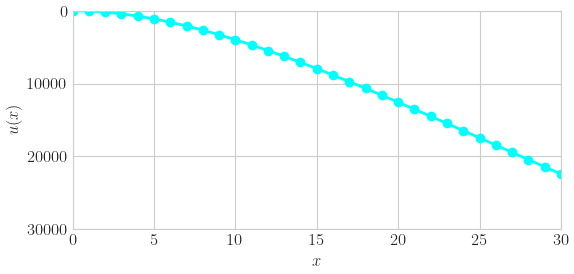

In [7]:
from matplotlib import pyplot
pyplot.style.use('../../../../qmcpy.mplstyle')
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(solution,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$')
ax.set_ylim([30000,-10]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [8]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [17]:
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=8)
solution,data = qp.CubQMCNetG(integrand,abs_tol=2.5).integrate()
data

LDTransformData (AccumulateData Object)
    solution        [    0.       47.403   183.785 ... 19837.561 20807.189 21776.923]
    comb_bound_low  [    0.       47.393   183.746 ... 19835.922 20805.478 21775.14 ]
    comb_bound_high [    0.       47.413   183.824 ... 19839.199 20808.9   21778.707]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(11)
    n               [1024. 1024. 1024. ... 2048. 2048. 2048.]
    time_integrate  5.615
CubQMCNetG (StoppingCriterion Object)
    abs_tol         2.500
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               31
    dvec            [ 0  1  2 ... 28 29 30]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

## Shut Down Docker Image

In [67]:
!docker rm -f muqbp_new

muqbp_new
